# Time Series Analysis with Pandapipes
This notebook demonstrates a time series analysis on a fluid network using the Pandapipes library. The network simulates fluid flow through a series of junctions and pipes with varying conditions, including temperature changes over time.


In [1]:
!pip install pandapipes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.9 MB/s eta 0:00:00
  Created wheel for pandapipes: filename=pandapipes-0.10.0-py3-none-any.whl size=1461491 sha256=a4d4add5aacab4f9eafc72d31d85630b2673e811565789264f6c3d55ed02f987
  Stored in directory: /root/.cache/pip/wheels/a0/11/72/509866aaed7666c70de32de8c1a1829b63549295921bfa0781
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131029 sha256=0bda8a61db9b56efe21ff264ddaef7bce1efa174c0b769683a2093f4adf20ff3
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
Successfully built pandapipes pandapower


#Importing libraries

In [34]:
import pandapipes as pp
import pandapower as ppw
import pandas as pd
import numpy as np
import tempfile
import logging

#Setting up logger

In [35]:
logger=logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

#Creating Network

We begin by setting up the fluid network, which includes creating junctions, pipes, and other components such as heat exchangers. The network is defined with specific parameters such as fluid type, pressure, and temperature at each junction.


In [36]:
net=pp.create_empty_network(fluid="water")

In [37]:
j0=pp.create_junction(net,pn_bar=1,tfluid_k=293.15,name="j0")
j1=pp.create_junction(net,pn_bar=1,tfluid_k=330.15,name="j1")
j2=pp.create_junction(net,pn_bar=1,tfluid_k=330.15,name="j2")
j3=pp.create_junction(net,pn_bar=1,tfluid_k=330.15,name="j3")
j4=pp.create_junction(net,pn_bar=1,tfluid_k=300.15,name="j4")

In [38]:
pp.create_pipe_from_parameters(net,from_junction=j0, to_junction=j1, length_km=1,diameter_m=0.1,name="Pipe 0-1")
pp.create_pipe_from_parameters(net,from_junction=j1, to_junction=j2, length_km=1,diameter_m=0.1,name="Pipe 1-2")
pp.create_pipe_from_parameters(net,from_junction=j2, to_junction=j3, length_km=1,diameter_m=0.1,name="Pipe 2-3")
pp.create_pipe_from_parameters(net,from_junction=j3, to_junction=j4, length_km=1,diameter_m=0.1,name="Pipe 3-4")
pp.create_pipe_from_parameters(net,from_junction=j4, to_junction=j0, length_km=1,diameter_m=0.1,name="Pipe 4-0")


4

In [39]:
pp.create_ext_grid(net, junction=j0,p_bar=1,t_k=330.15,name="External grid")

0

In [40]:

pp.create_heat_exchanger(net,from_junction=j2, to_junction=j3,diameter_m=0.1,qext_w=100000,name="Heat exchanger")
# pp.create_sink(net,junction=j1,mdot_kg_per_s=0.5,name="Sink 1")
# pp.create_sink(net,junction=j4,mdot_kg_per_s=0.5,name="Sink 2")

# Example: Modifying your code to use create_heat_consumer correctly
# Corrected code to use create_heat_consumer correctly
pp.create_heat_consumer(
    net,
    from_junction=j1,
    to_junction=j2,
    diameter_m=0.1,
    controlled_mdot_kg_per_s=0.5,  # Specify the controlled mass flow rate
    qext_w=10000,  # Specify the heat extraction rate in Watts
    name="Consumer 1"
)

pp.create_heat_consumer(
    net,
    from_junction=j3,
    to_junction=j4,
    diameter_m=0.1,
    controlled_mdot_kg_per_s=0.5,  # Specify the controlled mass flow rate
    qext_w=10000,  # Specify the heat extraction rate in Watts
    name="Consumer 2"
)



1

#creating dataframe for time varying profile

Time series profiles are created for the heat exchanger and consumers. These profiles represent the varying heat exchange and flow rates over the simulation period.


In [41]:
time_steps=24
time=pd.date_range('2024-01-01',periods=time_steps,freq='H')

heat_exchanger_profile=pd.Series([10000+5000*np.sin(2*np.pi*t/time_steps) for t in range(time_steps)],index=time)
consumer1_qext_profile = pd.Series([10000 + 1000 * np.sin(2 * np.pi * t / time_steps) for t in range(time_steps)], index=time)
consumer2_qext_profile = pd.Series([12000 + 800 * np.cos(2 * np.pi * t / time_steps) for t in range(time_steps)], index=time)

<ipython-input-41-703c963f60dc>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time=pd.date_range('2024-01-01',periods=time_steps,freq='H')


In [42]:
class DFData:
  def __init__(self,data):
    self.data=data

  def get_time_step_value(self,time_step,profile_name=None,scale_factor=1.0):
    value=self.data.iloc[time_step]
    return value*scale_factor


In [43]:
profiles={
    "heat_exchanger":DFData(heat_exchanger_profile),
    "consumer1":DFData(consumer1_qext_profile),
    "consumer2":DFData(consumer2_qext_profile)
}

In [44]:
heatexchangerdata=profiles["heat_exchanger"]

print(heatexchangerdata.data)

2024-01-01 00:00:00    10000.000000
2024-01-01 01:00:00    11294.095226
2024-01-01 02:00:00    12500.000000
2024-01-01 03:00:00    13535.533906
2024-01-01 04:00:00    14330.127019
2024-01-01 05:00:00    14829.629131
2024-01-01 06:00:00    15000.000000
2024-01-01 07:00:00    14829.629131
2024-01-01 08:00:00    14330.127019
2024-01-01 09:00:00    13535.533906
2024-01-01 10:00:00    12500.000000
2024-01-01 11:00:00    11294.095226
2024-01-01 12:00:00    10000.000000
2024-01-01 13:00:00     8705.904774
2024-01-01 14:00:00     7500.000000
2024-01-01 15:00:00     6464.466094
2024-01-01 16:00:00     5669.872981
2024-01-01 17:00:00     5170.370869
2024-01-01 18:00:00     5000.000000
2024-01-01 19:00:00     5170.370869
2024-01-01 20:00:00     5669.872981
2024-01-01 21:00:00     6464.466094
2024-01-01 22:00:00     7500.000000
2024-01-01 23:00:00     8705.904774
Freq: h, dtype: float64


In [45]:
sinkdata=profiles['consumer1']

print(sinkdata.data)

2024-01-01 00:00:00    10000.000000
2024-01-01 01:00:00    10258.819045
2024-01-01 02:00:00    10500.000000
2024-01-01 03:00:00    10707.106781
2024-01-01 04:00:00    10866.025404
2024-01-01 05:00:00    10965.925826
2024-01-01 06:00:00    11000.000000
2024-01-01 07:00:00    10965.925826
2024-01-01 08:00:00    10866.025404
2024-01-01 09:00:00    10707.106781
2024-01-01 10:00:00    10500.000000
2024-01-01 11:00:00    10258.819045
2024-01-01 12:00:00    10000.000000
2024-01-01 13:00:00     9741.180955
2024-01-01 14:00:00     9500.000000
2024-01-01 15:00:00     9292.893219
2024-01-01 16:00:00     9133.974596
2024-01-01 17:00:00     9034.074174
2024-01-01 18:00:00     9000.000000
2024-01-01 19:00:00     9034.074174
2024-01-01 20:00:00     9133.974596
2024-01-01 21:00:00     9292.893219
2024-01-01 22:00:00     9500.000000
2024-01-01 23:00:00     9741.180955
Freq: h, dtype: float64


#Making Controllers

In [46]:
from pandapower.control import ConstControl
from pandapipes.timeseries.run_time_series import run_timeseries

In [47]:
heat_exchanger_control=ConstControl(net,element='heat_exchanger',variable='qext_w', element_index=[0],profile_name='heat_exchanger',data_source=profiles['heat_exchanger'])
consumer1_control = ConstControl(
    net,
    element='heat_consumer',
    variable='qext_w',
    element_index=[0],
    profile_name='consumer1',
    data_source=profiles['consumer1']
)

consumer2_control = ConstControl(
    net,
    element='heat_consumer',
    variable='qext_w',
    element_index=[1],
    profile_name='consumer2',
    data_source=profiles['consumer2']
)

In [48]:
print(profiles['consumer1'].data)

2024-01-01 00:00:00    10000.000000
2024-01-01 01:00:00    10258.819045
2024-01-01 02:00:00    10500.000000
2024-01-01 03:00:00    10707.106781
2024-01-01 04:00:00    10866.025404
2024-01-01 05:00:00    10965.925826
2024-01-01 06:00:00    11000.000000
2024-01-01 07:00:00    10965.925826
2024-01-01 08:00:00    10866.025404
2024-01-01 09:00:00    10707.106781
2024-01-01 10:00:00    10500.000000
2024-01-01 11:00:00    10258.819045
2024-01-01 12:00:00    10000.000000
2024-01-01 13:00:00     9741.180955
2024-01-01 14:00:00     9500.000000
2024-01-01 15:00:00     9292.893219
2024-01-01 16:00:00     9133.974596
2024-01-01 17:00:00     9034.074174
2024-01-01 18:00:00     9000.000000
2024-01-01 19:00:00     9034.074174
2024-01-01 20:00:00     9133.974596
2024-01-01 21:00:00     9292.893219
2024-01-01 22:00:00     9500.000000
2024-01-01 23:00:00     9741.180955
Freq: h, dtype: float64


In [ ]:
# net.controller.loc[len(net.controller)] = {
#     'object': heat_exchanger_control,
#     'in_service': True,
#     'level': 0,
#     'order': 0
# }

# net.controller.loc[len(net.controller)] = {
#     'object': consumer1_control,
#     'in_service': True,
#     'level': 0,
#     'order': 1
# }

# net.controller.loc[len(net.controller)] = {
#     'object': consumer2_control,
#     'in_service': True,
#     'level': 0,
#     'order': 2
# }

In [49]:
len(net.controller)

3

In [24]:
# Remove all existing controllers (if you want to start fresh)
net.controller.drop(net.controller.index, inplace=True)


In [18]:
# import pandas as pd

# # Create a list of controllers to be added
# controllers = pd.DataFrame([
#     {
#         'object': heat_exchanger_control,
#         'in_service': True,
#         'level': 0,
#         'order': 0
#     },
#     {
#         'object': consumer1_control,
#         'in_service': True,
#         'level': 0,
#         'order': 1
#     },
#     {
#         'object': consumer2_control,
#         'in_service': True,
#         'level': 0,
#         'order': 2
#     }
# ])

# # Now, use pandas.concat to add the controllers to the net.controller DataFrame
# net.controller = pd.concat([net.controller, controllers], ignore_index=True)


In [29]:
print(net.controller)

                                 object  in_service  order level initial_run  \
0  ConstControl [heat_exchanger.qext_w]        True   -1.0    -1       False   
1   ConstControl [heat_consumer.qext_w]        True   -1.0    -1       False   
2   ConstControl [heat_consumer.qext_w]        True   -1.0    -1       False   

  recycle  
0   False  
1   False  
2   False  


# Making custom Output writer to log the results

In [50]:
import os


# Custom init_default_outputwriter function
def custom_init_default_outputwriter(net, time_steps, **kwargs):
    output_writer = kwargs.get("output_writer", None)
    if output_writer is not None:
        net.output_writer.iat[0, 0] = output_writer
    if "output_writer" not in net or net.output_writer.iat[0, 0] is None:
        ow = ppw.timeseries.OutputWriter(net, time_steps, output_path=tempfile.gettempdir(), log_variables=[])
        # Logging variables for elements that exist in the pandapipes network
        if 'heat_consumer' in net:
            ow.log_variable('res_heat_consumer', 'mdot_from_kg_per_s')


        if 'ext_grid' in net:
            ow.log_variable('res_ext_grid', 'mdot_kg_per_s')
        if 'pipe' in net:
            ow.log_variable('res_pipe', 'v_mean_m_per_s')
            # Add temperature logging for pipes if available
            ow.log_variable('res_pipe', 't_from_k')  # Temperature at the start of the pipe
            ow.log_variable('res_pipe', 't_to_k')    # Temperature at the end of the pipe
        if 'junction' in net:
            ow.log_variable('res_junction', 'p_bar')
            ow.log_variable('res_junction', 't_k')
        if 'heat_exchanger' in net:
            ow.log_variable('res_heat_exchanger', 'mdot_from_kg_per_s')
        net.output_writer.iat[0, 0] = ow
        logger.info("Using custom output writer configuration.")
    return net.output_writer.iat[0, 0]


## Running the Time Series Simulation
The time series simulation is run over the defined period. The network's state, including pressures, flow rates, and temperatures, is updated at each time step.


In [ ]:
# output_path = "/content/simulation_results.csv"

# # Initialize and run the time series simulation
# ow = custom_init_default_outputwriter(net, time_steps, output_path=output_path)

# run_timeseries(net, time_steps=list(range(time_steps)))

# # Output the results
# print("Time Series Simulation Results:")
# print(net.res_junction)
# print(net.res_pipe)

100%|██████████| 24/24 [00:00<00:00, 38.01it/s]

Time Series Simulation Results:
      p_bar     t_k
0  1.000000  330.15
1  0.998087  293.15
2  1.000164  300.15
3  1.000164  300.15
4  1.002170  300.15
   v_mean_m_per_s  p_from_bar  p_to_bar  t_from_k  t_to_k  mdot_from_kg_per_s  \
0    3.228626e-02    1.000000  0.998087    330.15  293.15        2.535453e-01   
1   -3.138335e-02    0.998087  1.000164    293.15  300.15       -2.464547e-01   
2   -1.483468e-21    1.000164  1.000164    300.15  300.15       -1.164974e-20   
3   -3.138335e-02    1.000164  1.002170    300.15  300.15       -2.464547e-01   
4    3.228626e-02    1.002170  1.000000    300.15  330.15        2.535453e-01   

   mdot_to_kg_per_s  vdot_norm_m3_per_s      reynolds        lambda  
0     -2.535453e-01        2.535757e-04  4.810954e+03  3.670667e-02  
1      2.464547e-01       -2.464842e-04  3.409561e+03  4.217444e-02  
2      1.164974e-20       -1.165113e-23  6.487927e-09  9.864476e+09  
3      2.464547e-01       -2.464842e-04  3.689402e+03  4.075069e-02  
4     -2.53

In [51]:
from pandapipes.timeseries.run_time_series import run_timeseries

output_path = "/content/simulation_results.csv"

# Initialize and run the time series simulation
ow = custom_init_default_outputwriter(net, time_steps, output_path=output_path)

# Function to track parameter changes after each step
def custom_run_timeseries_with_logging(net, time_steps):
    # Run time series with manual inspection
    for time_step in range(time_steps):
        # Run one time step
        run_timeseries(net, time_steps=[time_step])

        # Print or log the value of qext_w for the heat exchanger
        print(f"Time step {time_step}: qext_w of heat_exchanger = {net.heat_exchanger.qext_w}")

        # You can log other parameters like temperature or mass flow rates
        print(f"Time step {time_step}: t_to_k of heat_exchanger = {net.res_heat_exchanger.t_to_k}")
        # log pipes temperature
        print(f"Time step {time_step}: t_to_k of pipe = {net.res_pipe.t_to_k}")

# Call the custom time series function
custom_run_timeseries_with_logging(net, time_steps)


/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 1/1 [00:00<00:00, 31.31it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas.

Time step 0: qext_w of heat_exchanger = 0    10000.0
Name: qext_w, dtype: float64
Time step 0: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 0: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 32.79it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 1: qext_w of heat_exchanger = 0    11294.095226
Name: qext_w, dtype: float64
Time step 1: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 1: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 38.96it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 2: qext_w of heat_exchanger = 0    12500.0
Name: qext_w, dtype: float64
Time step 2: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 2: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 33.70it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 3: qext_w of heat_exchanger = 0    13535.533906
Name: qext_w, dtype: float64
Time step 3: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 3: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 19.98it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 4: qext_w of heat_exchanger = 0    14330.127019
Name: qext_w, dtype: float64
Time step 4: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 4: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 5: qext_w of heat_exchanger = 0    14829.629131
Name: qext_w, dtype: float64
Time step 5: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 5: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 27.68it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 6: qext_w of heat_exchanger = 0    15000.0
Name: qext_w, dtype: float64
Time step 6: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 6: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 29.73it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 7: qext_w of heat_exchanger = 0    14829.629131
Name: qext_w, dtype: float64
Time step 7: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 7: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 29.65it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 8: qext_w of heat_exchanger = 0    14330.127019
Name: qext_w, dtype: float64
Time step 8: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 8: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 33.27it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps


Time step 9: qext_w of heat_exchanger = 0    13535.533906
Name: qext_w, dtype: float64
Time step 9: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 9: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 1/1 [00:00<00:00, 36.83it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps


Time step 10: qext_w of heat_exchanger = 0    12500.0
Name: qext_w, dtype: float64
Time step 10: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 10: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 1/1 [00:00<00:00, 36.23it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future

Time step 11: qext_w of heat_exchanger = 0    11294.095226
Name: qext_w, dtype: float64
Time step 11: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 11: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 27.79it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps


Time step 12: qext_w of heat_exchanger = 0    10000.0
Name: qext_w, dtype: float64
Time step 12: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 12: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 1/1 [00:00<00:00, 33.07it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future

Time step 13: qext_w of heat_exchanger = 0    8705.904774
Name: qext_w, dtype: float64
Time step 13: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 13: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 14: qext_w of heat_exchanger = 0    7500.0
Name: qext_w, dtype: float64
Time step 14: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 14: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 30.49it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 15: qext_w of heat_exchanger = 0    6464.466094
Name: qext_w, dtype: float64
Time step 15: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 15: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 31.79it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 16: qext_w of heat_exchanger = 0    5669.872981
Name: qext_w, dtype: float64
Time step 16: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 16: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 24.57it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 17: qext_w of heat_exchanger = 0    5170.370869
Name: qext_w, dtype: float64
Time step 17: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 17: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 23.54it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 18: qext_w of heat_exchanger = 0    5000.0
Name: qext_w, dtype: float64
Time step 18: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 18: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


Time step 19: qext_w of heat_exchanger = 0    5170.370869
Name: qext_w, dtype: float64

/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values



Time step 19: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 19: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 24.72it/s]


Time step 20: qext_w of heat_exchanger = 0    5669.872981
Name: qext_w, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 20: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 20: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 25.60it/s]


Time step 21: qext_w of heat_exchanger = 0    6464.466094
Name: qext_w, dtype: float64

/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values



Time step 21: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 21: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]
/usr/local/lib/python3.10/dist-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[23]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/usr/local/lib/python3.10/dist-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values


Time step 22: qext_w of heat_exchanger = 0    7500.0
Name: qext_w, dtype: float64
Time step 22: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 22: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


100%|██████████| 1/1 [00:00<00:00, 25.89it/s]

Time step 23: qext_w of heat_exchanger = 0    8705.904774
Name: qext_w, dtype: float64
Time step 23: t_to_k of heat_exchanger = 0    330.15
Name: t_to_k, dtype: float64
Time step 23: t_to_k of pipe = 0    330.15
1    330.15
2    330.15
3    300.15
4    330.15
Name: t_to_k, dtype: float64


## Logging and Analyzing Results
The results of the simulation, including junction pressures and pipe flow rates, are logged and saved for further analysis. The results are also visualized to understand the dynamic behavior of the network.


In [33]:
output_data = {}

# Collecting the logged data from the output_writer
for key, value in net.output_writer.iat[0, 0].output.items():
    output_data[key] = value

output_path = "/content/simulation_results_manual.xlsx"

# Save each logged variable to a separate sheet in the Excel file
with pd.ExcelWriter(output_path) as writer:
    for key, df in output_data.items():
        df.to_excel(writer, sheet_name=key)

# Check if the file was created
if os.path.exists(output_path):
    print(f"Logs successfully saved to: {output_path}")
else:
    print(f"Failed to save logs to: {output_path}")

Logs successfully saved to: /content/simulation_results_manual.xlsx


/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Plotting Network
The network topology is plotted, showing the connections between junctions and pipes. Additionally, the results of the time series simulation are visualized, highlighting the temperature distribution across the network.


In [52]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.0 MB/s eta 0:00:00


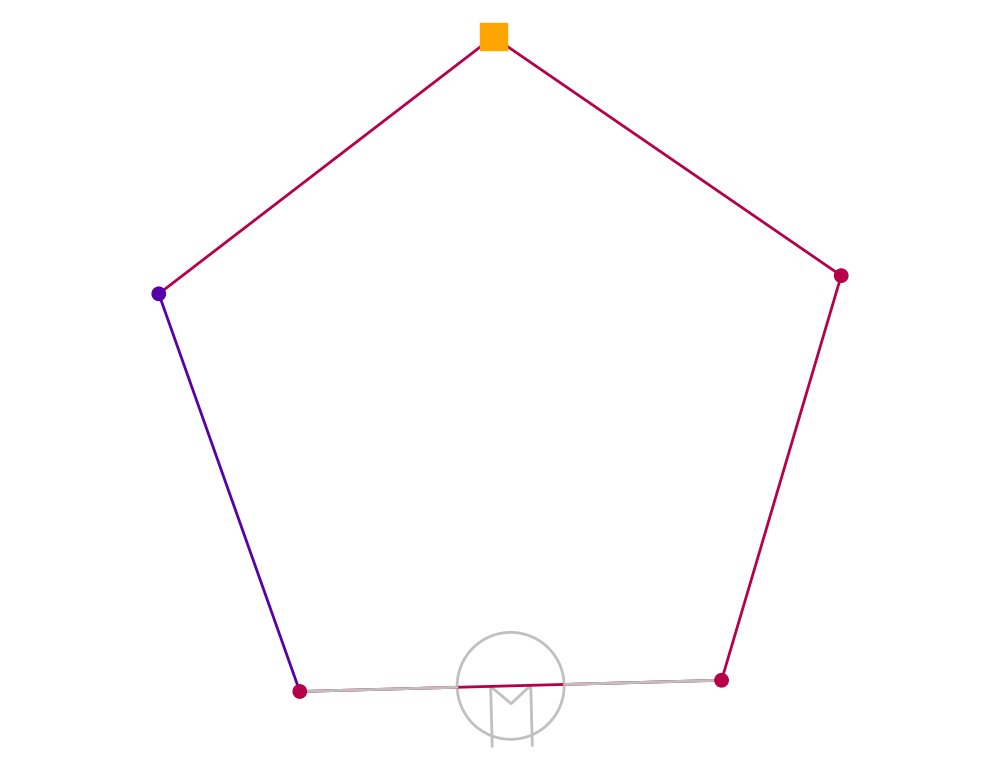

In [54]:
from colormaps import cmap_continuous
import matplotlib.colors as mcolors
import pandapipes.plotting as plot
import matplotlib.pyplot as plt

# Preprocess temperature data to get colors for junctions
temperatures = net.res_junction.t_k.values

# Use custom colormap function
cmap, norm = cmap_continuous([(273.15, "blue"), (353.15, "red")])
junction_colors = [mcolors.rgb2hex(cmap(norm(temp))) for temp in temperatures]

# Get the temperature data for pipes (t_to_k from pipe results)
pipe_temperatures = net.res_pipe.t_to_k.values
pipe_colors = [mcolors.rgb2hex(cmap(norm(temp))) for temp in pipe_temperatures]

# Now, pass the colors directly to simple_plot
plot.simple_plot(
    net,
    pipe_color=pipe_colors,  # Pass the custom pipe colors here
    plot_sinks=True,
    plot_sources=True,
    plot_ext_grids=True,
    junction_color=junction_colors,
)

plt.show()

In [ ]:
temperatures

print(cmap)
print(norm)



NameError: name 'cmap' is not defined

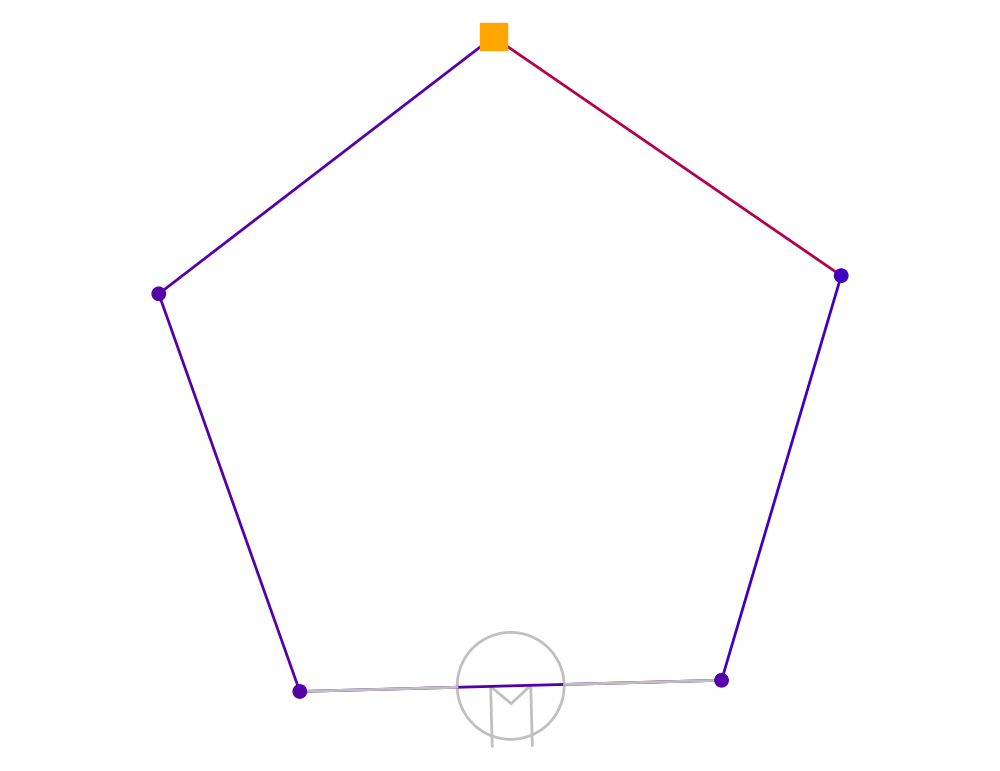

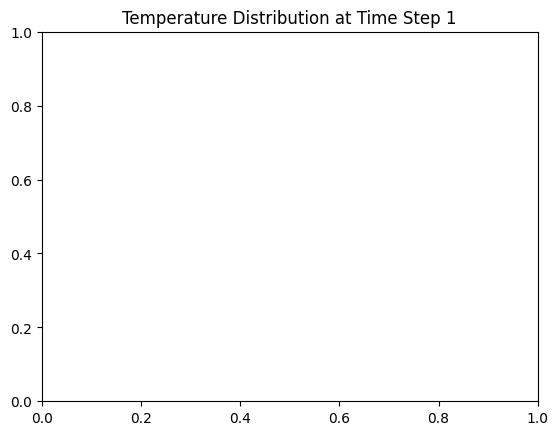

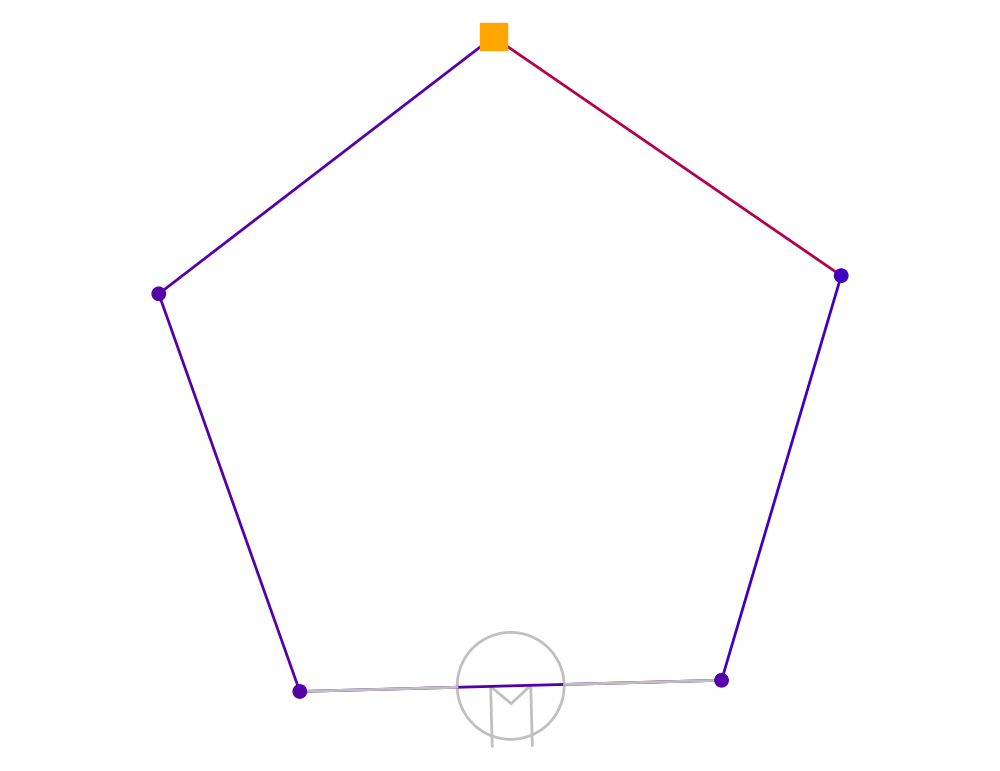

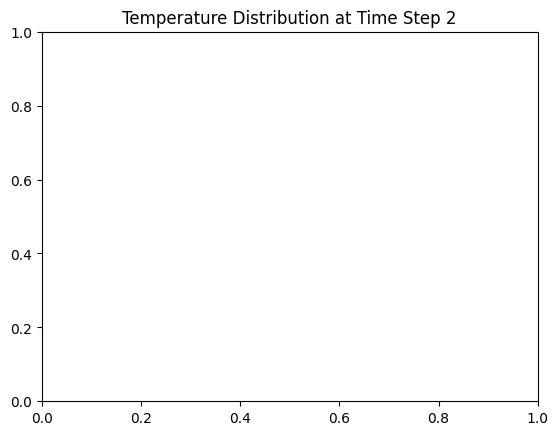

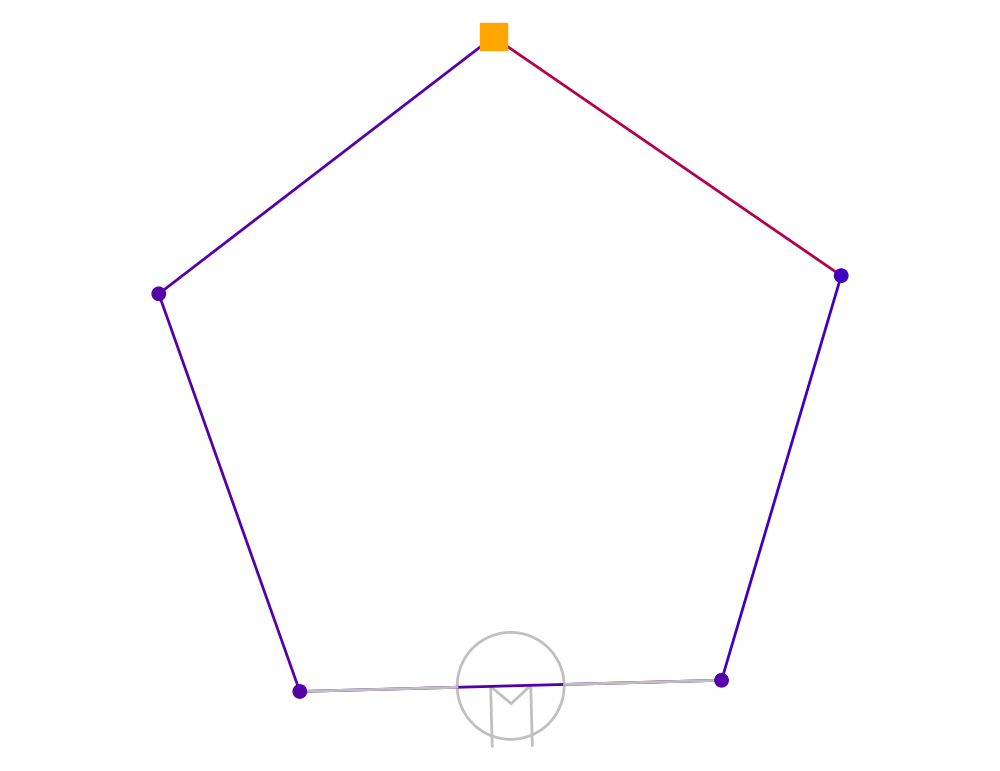

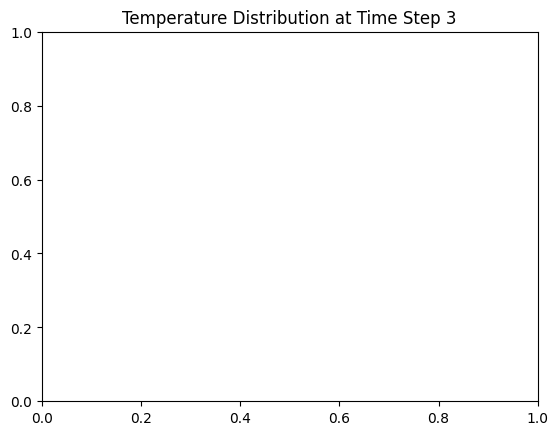

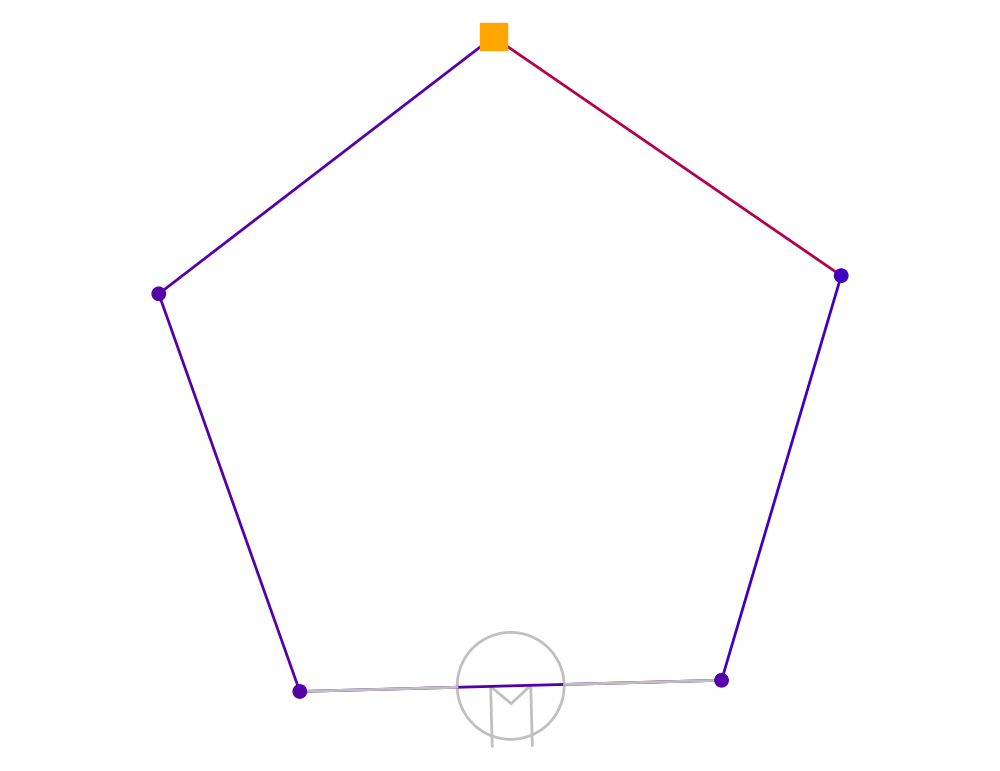

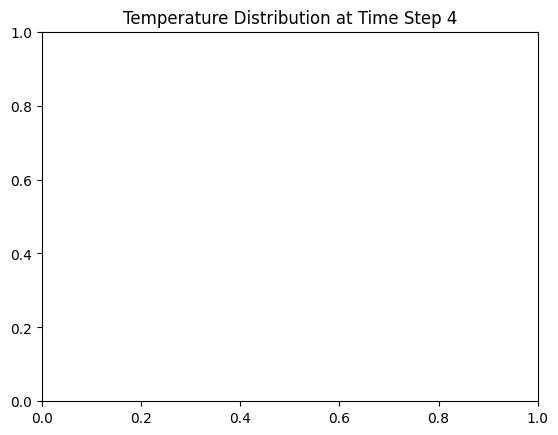

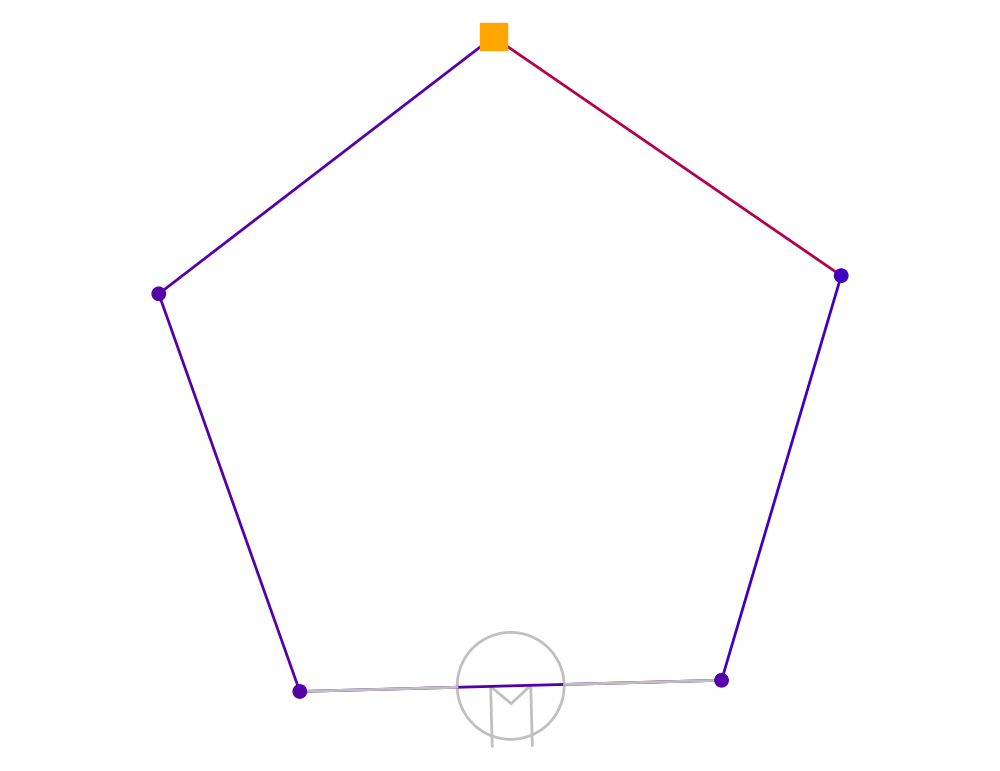

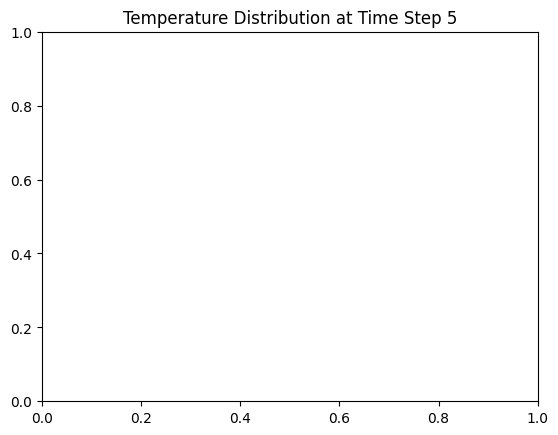

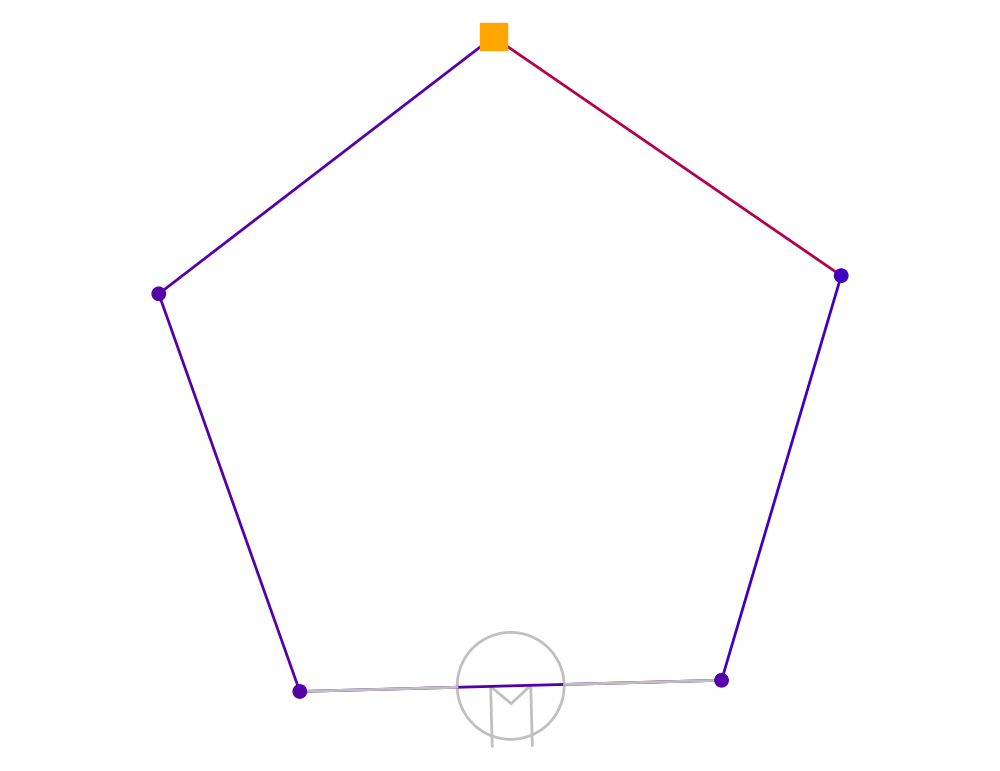

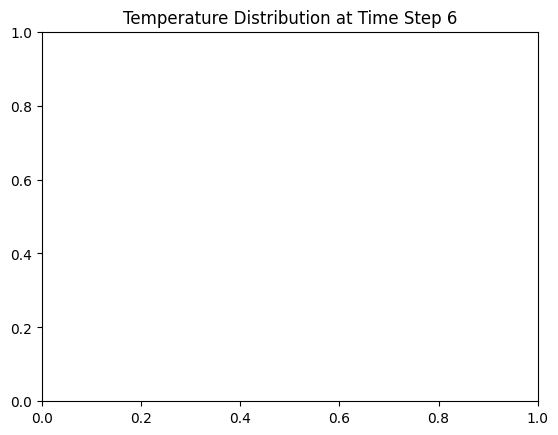

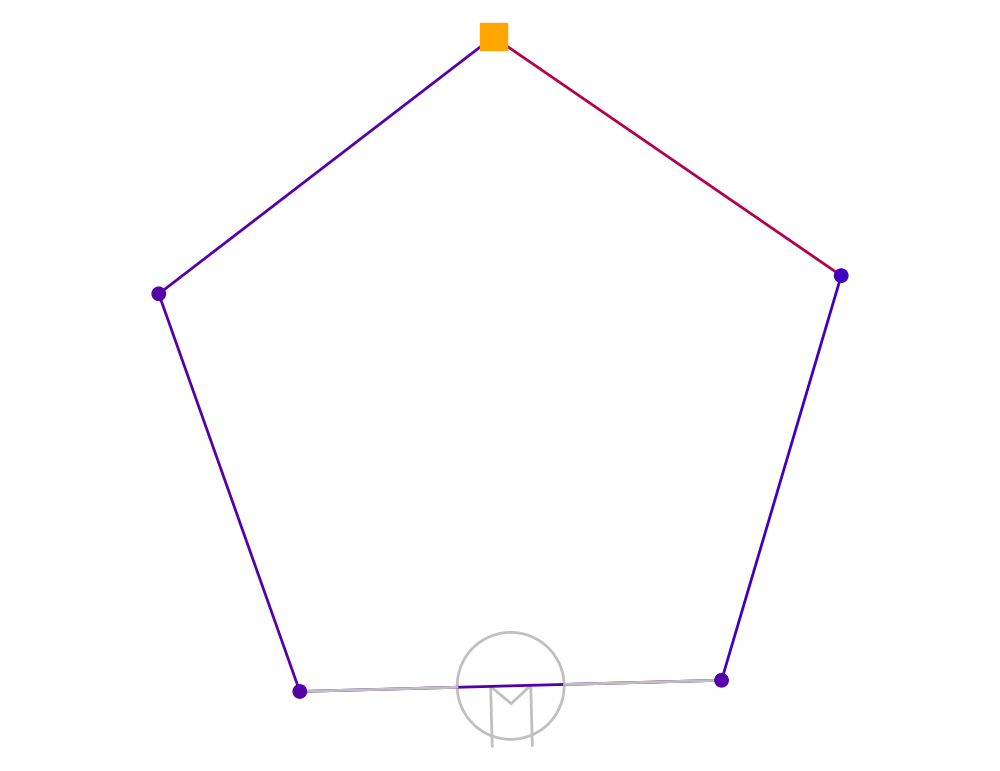

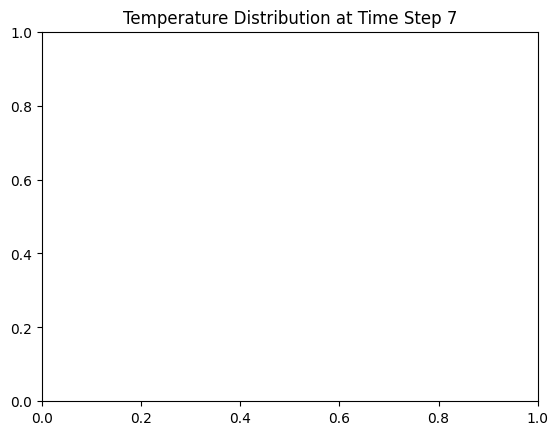

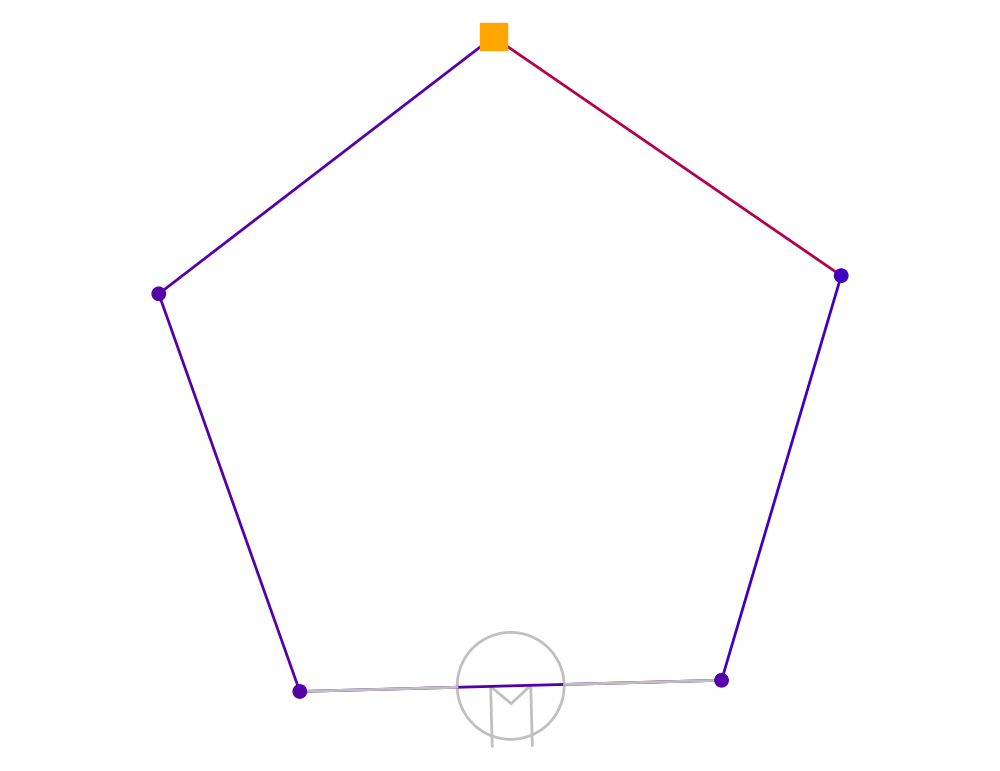

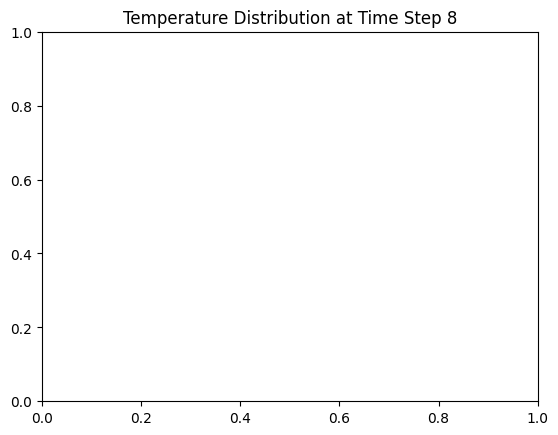

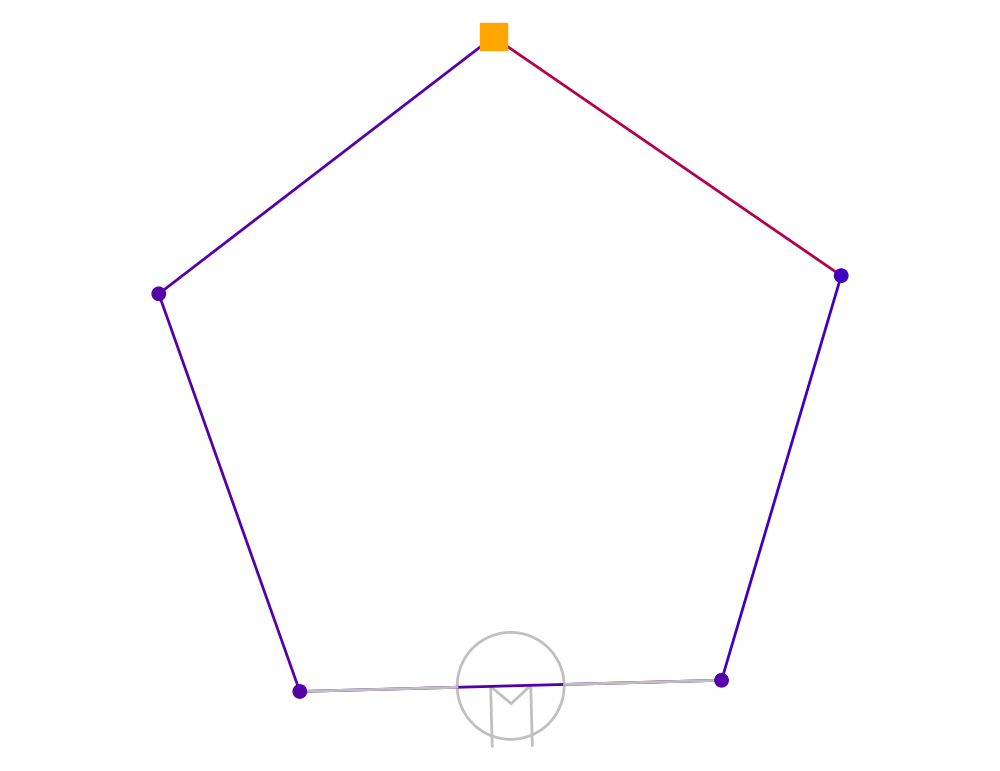

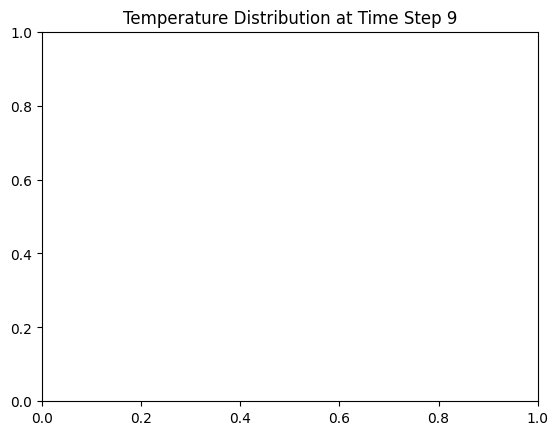

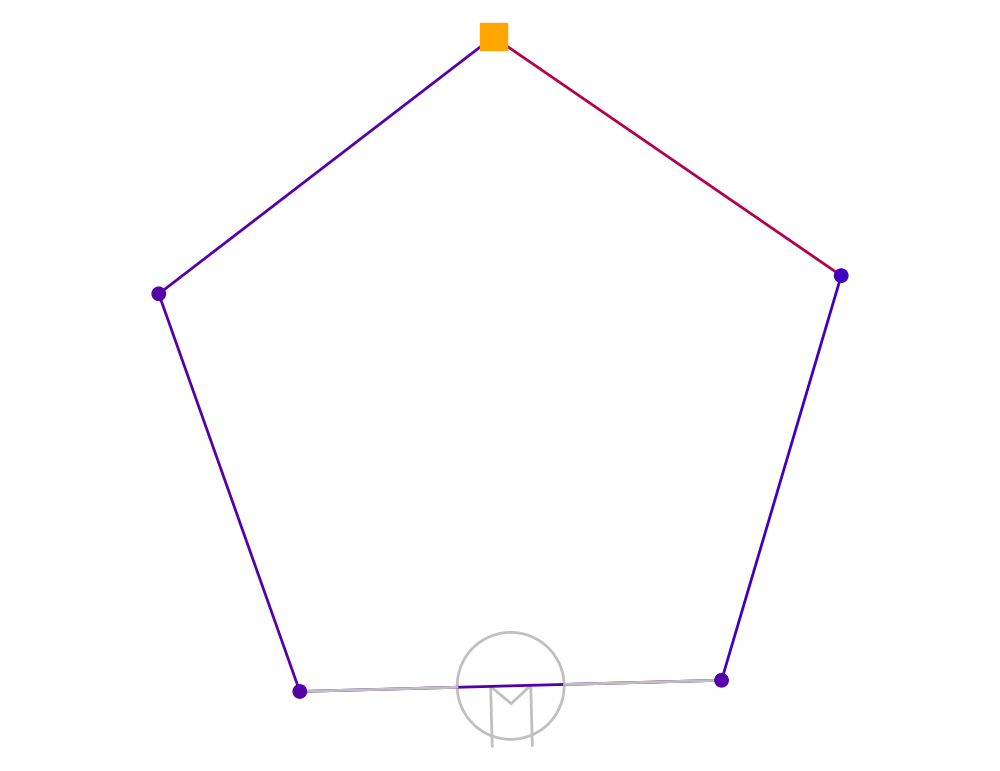

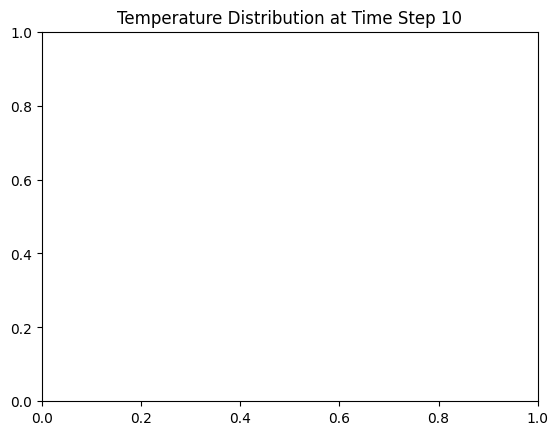

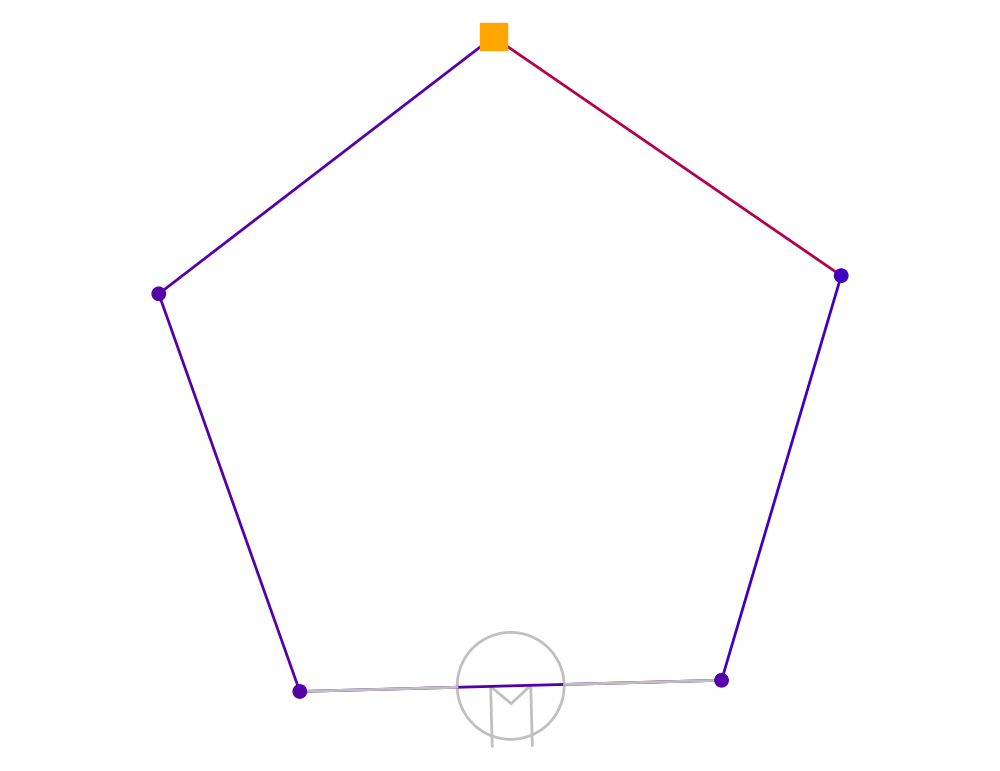

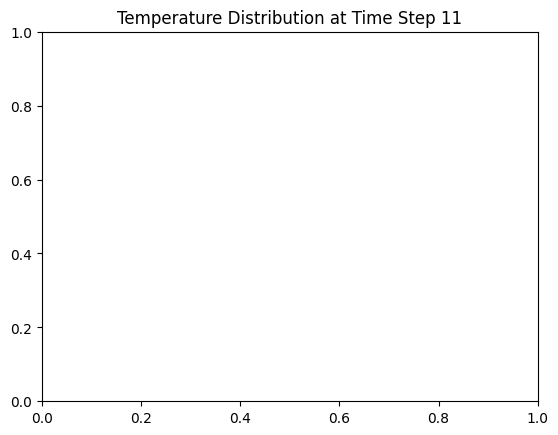

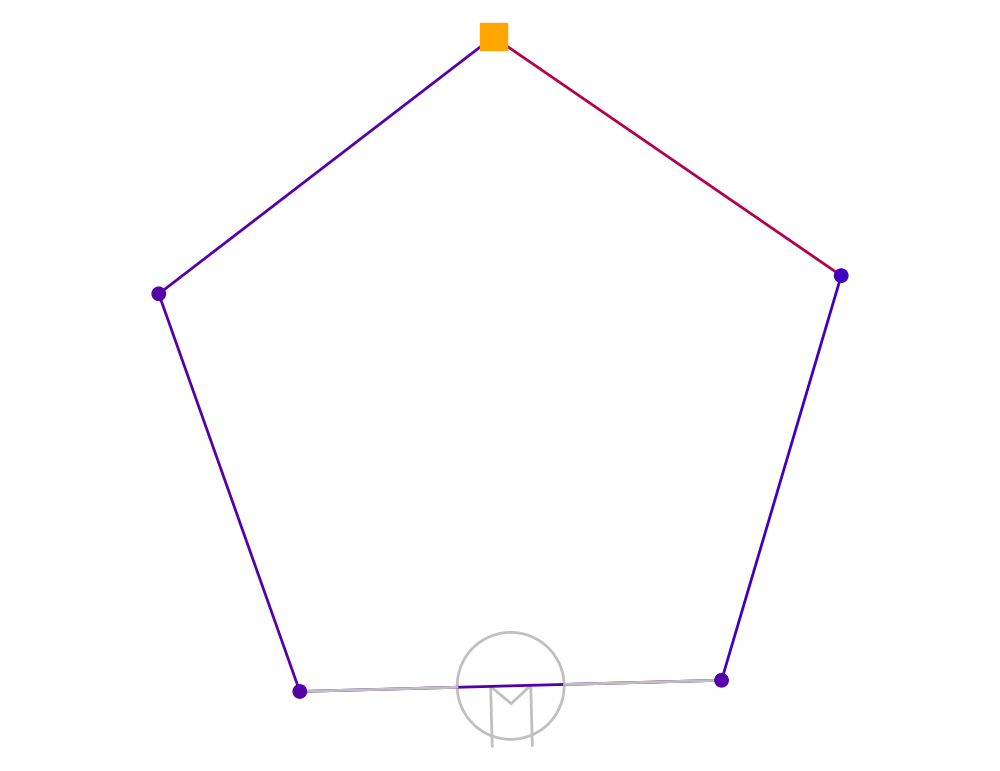

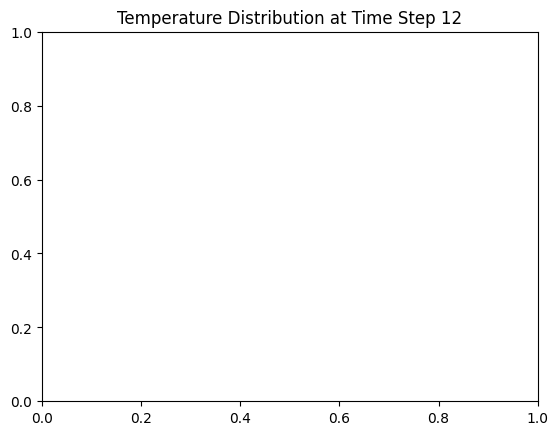

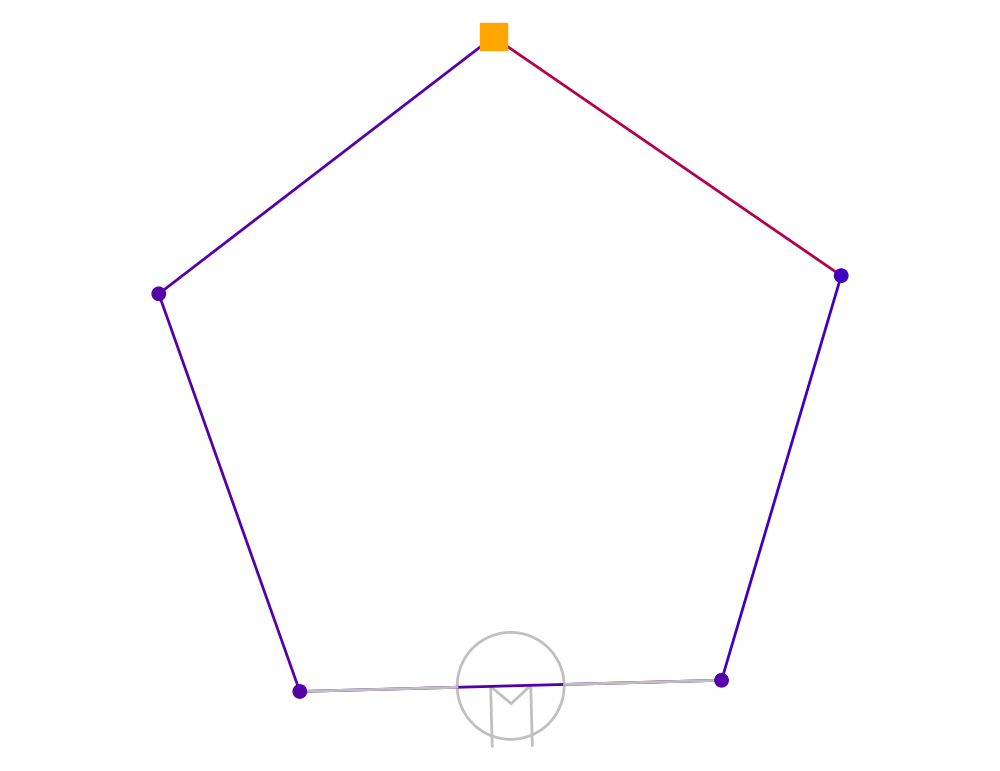

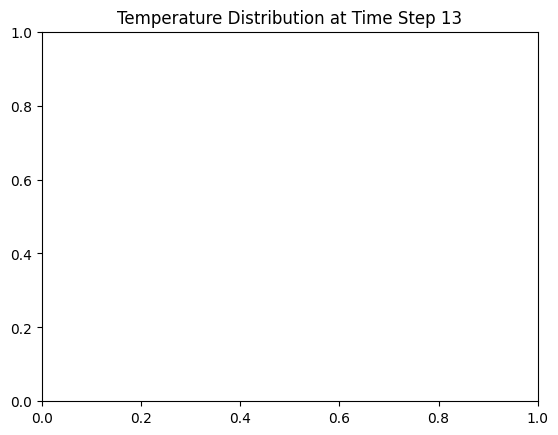

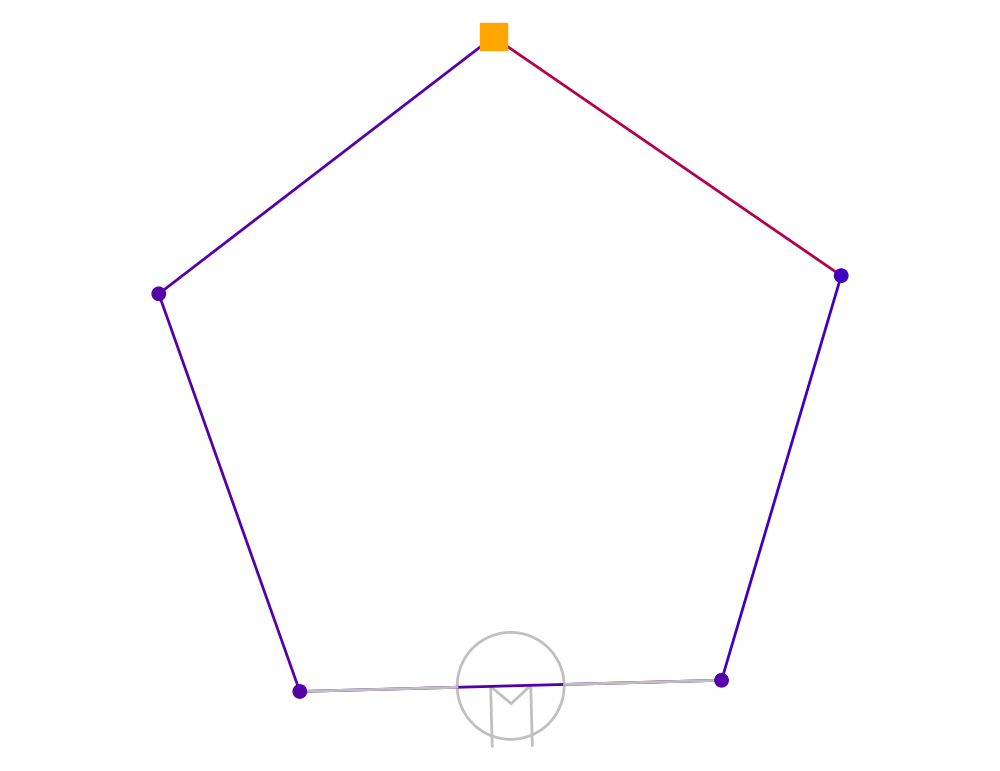

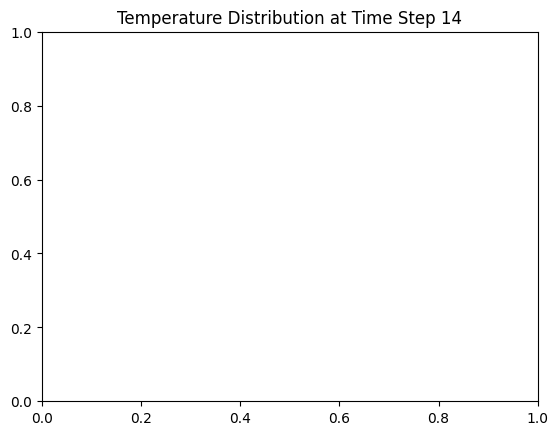

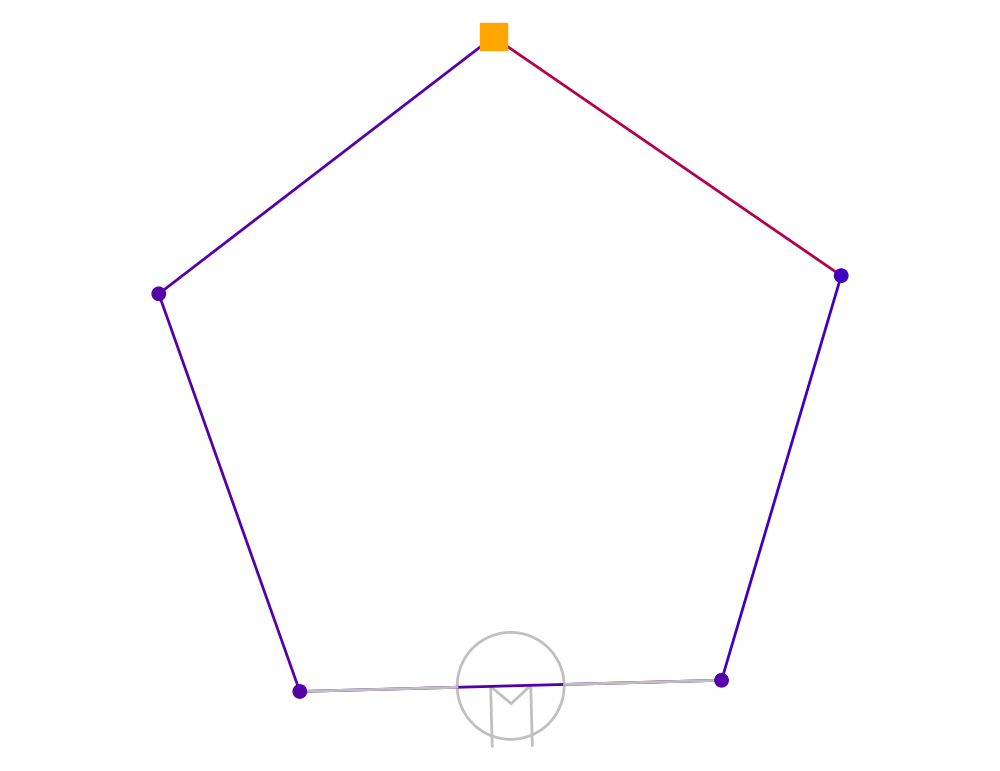

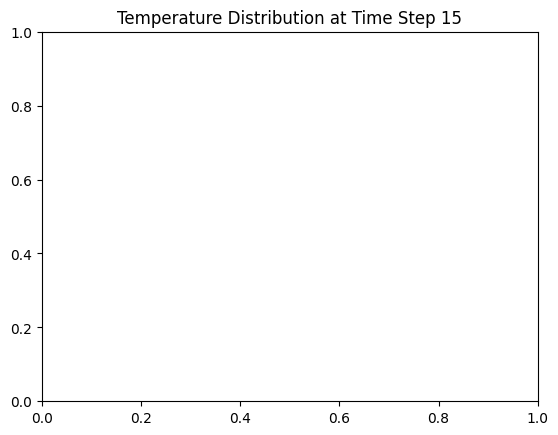

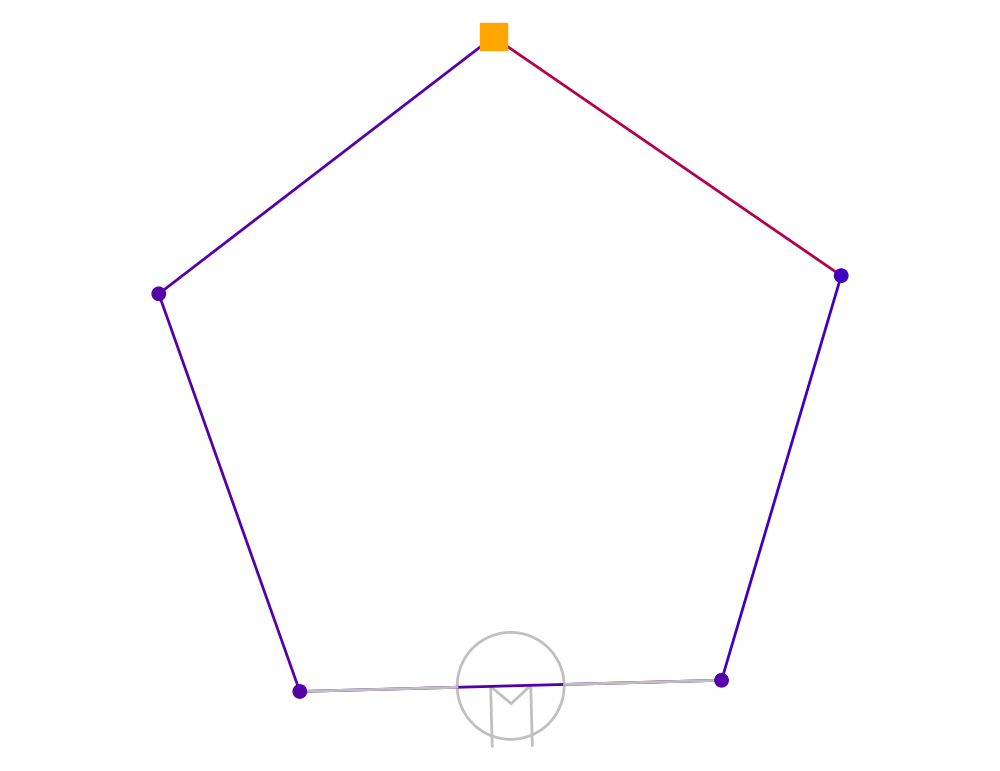

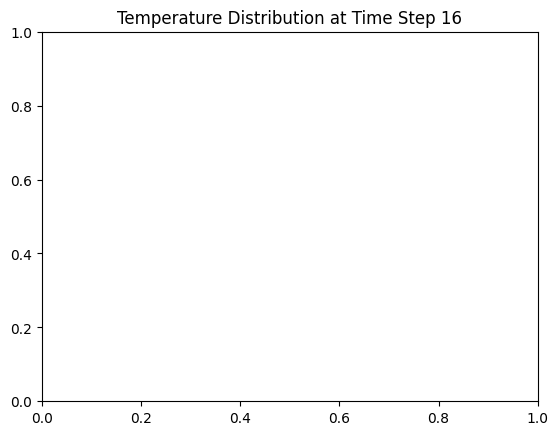

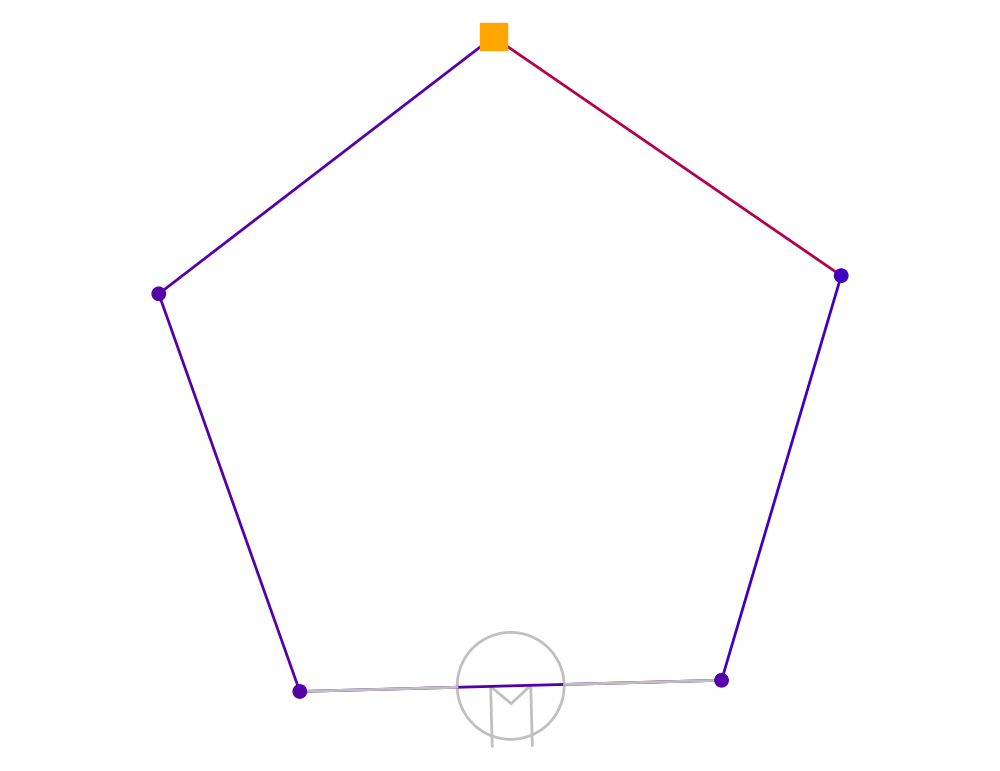

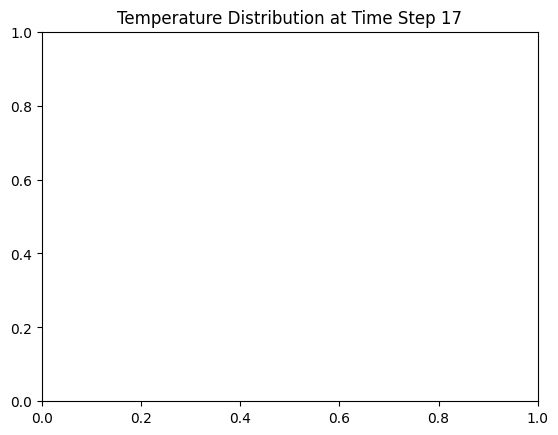

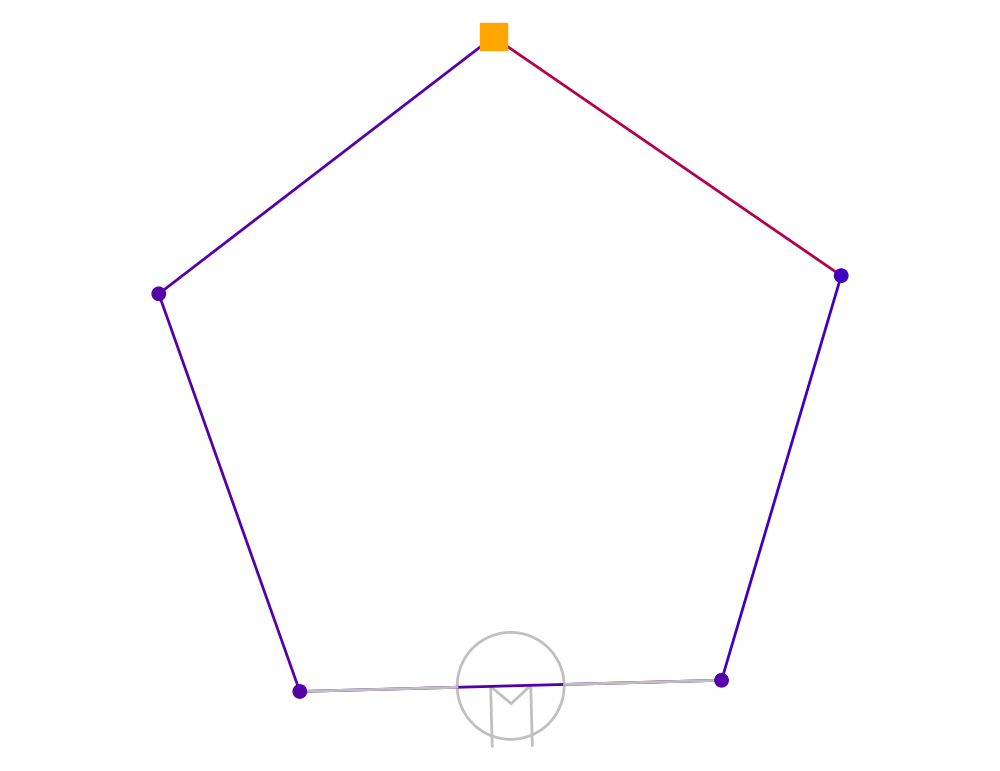

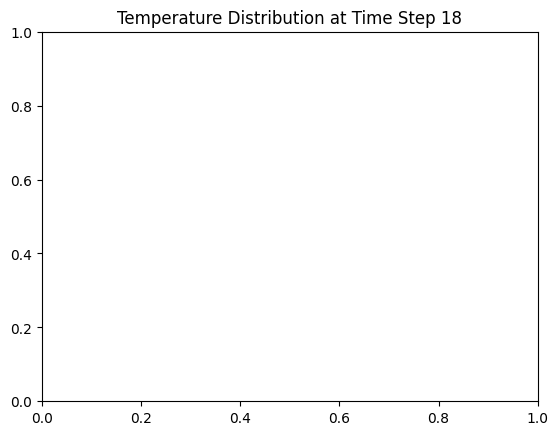

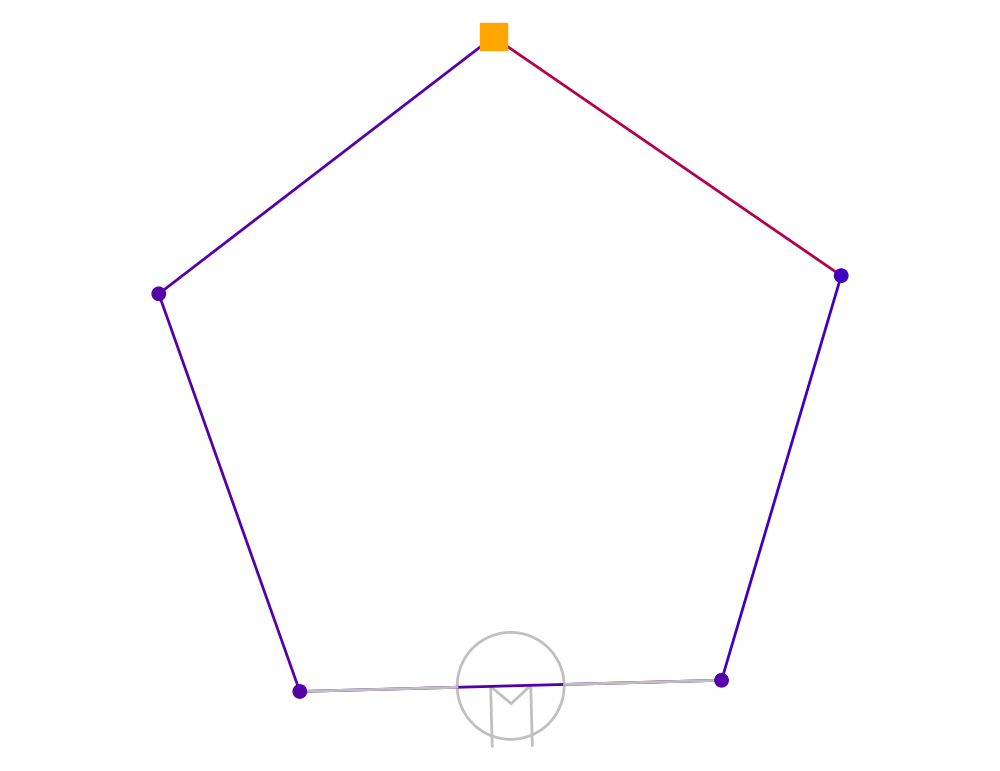

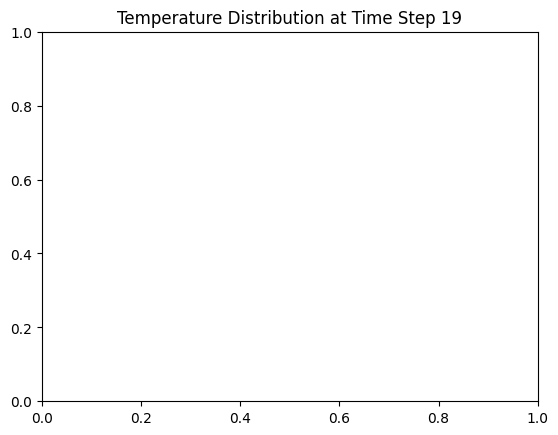

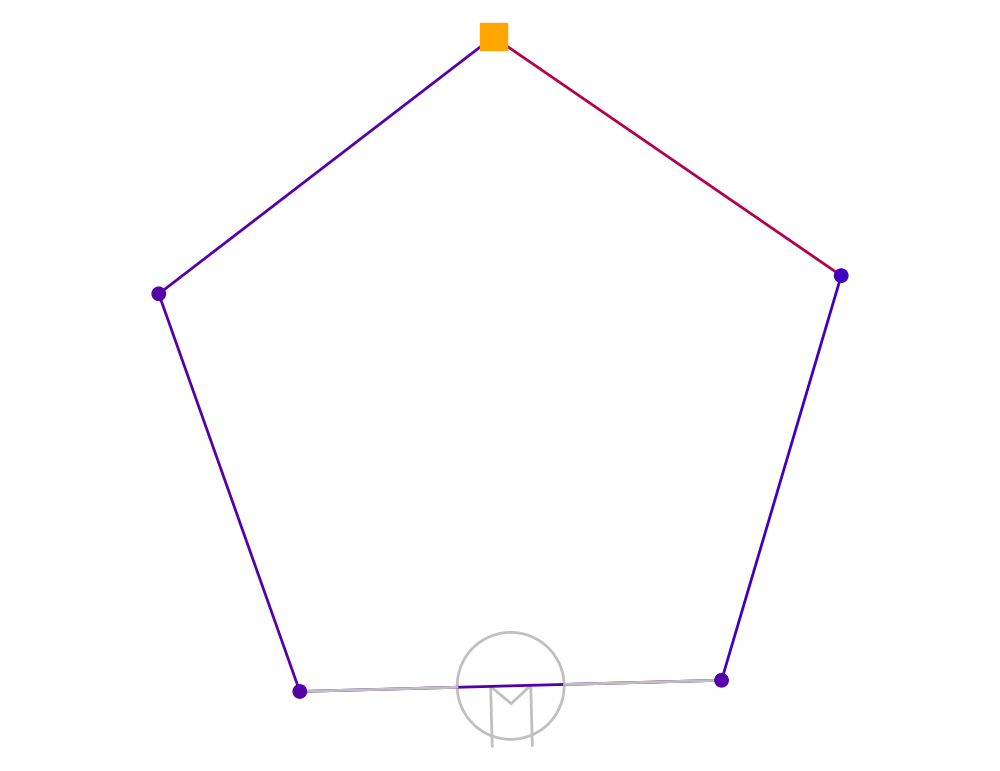

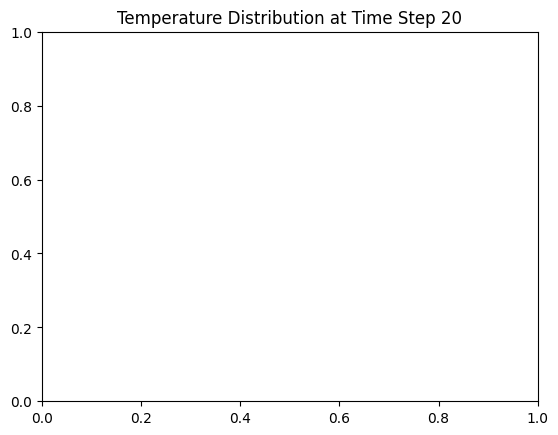

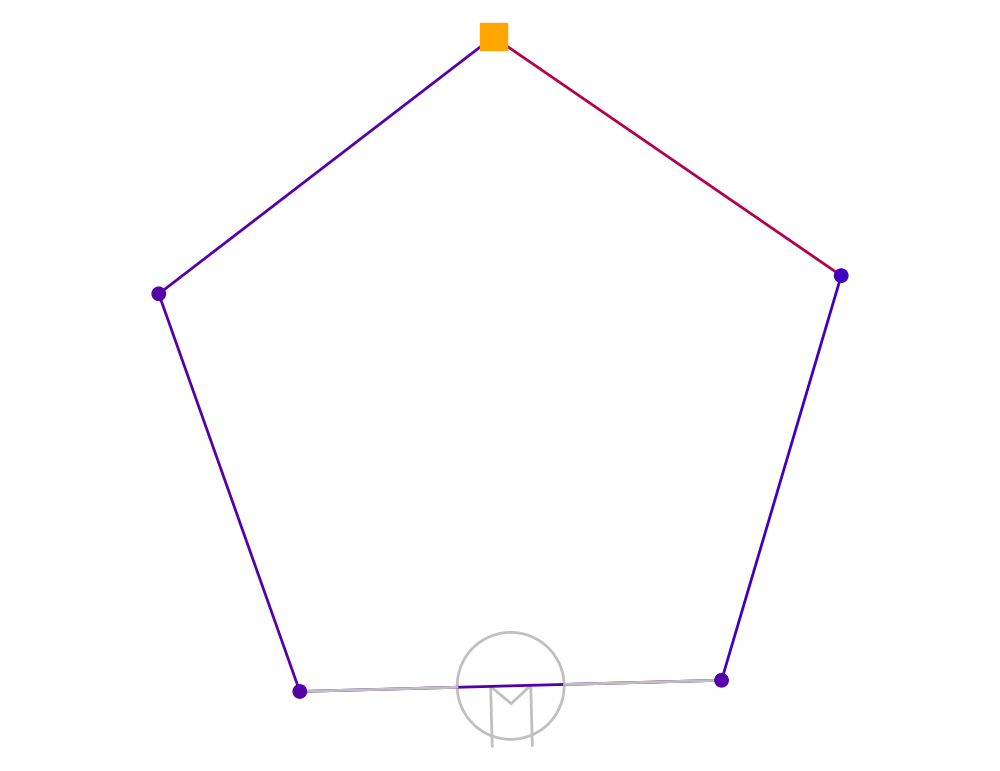

KeyboardInterrupt: 

In [ ]:
# Load Excel data
file_path = "/content/simulation_results_manual.xlsx"

junction_temperature_data = pd.read_excel(file_path, sheet_name='res_junction.t_k')

# Assuming pipe temperatures need to be derived or set similarly if data was available
# For now, we use junction temperatures for both to demonstrate
pipe_temperature_data = junction_temperature_data.copy()  # If similar data were available

# Define the custom colormap for temperature visualization
cmap, norm = cmap_continuous([(273.15, "blue"), (353.15, "red")])

# Loop through each time step to generate individual plots
for step in range(len(junction_temperature_data)):
    # Extract temperatures for this time step
    temperatures_junction = junction_temperature_data.iloc[step, 1:].values  # Excluding the time step column
    junction_names = junction_temperature_data.columns[1:]  # Get junction names

    # Convert temperatures to colors using the custom colormap
    junction_colors = [mcolors.rgb2hex(cmap(norm(temp))) for temp in temperatures_junction]

    # Assuming pipe data can be derived similarly; if real data were available, replace this
    temperatures_pipe = pipe_temperature_data.iloc[step, 1:].values  # Excluding the time step column
    pipe_colors = [mcolors.rgb2hex(cmap(norm(temp))) for temp in temperatures_pipe]

    # Plotting using pandapipes plotting functionality
    plot.simple_plot(
        net,  # Replace 'net' with your actual pandapipes network object
        pipe_color=pipe_colors,  # Pass the custom pipe colors
        plot_sinks=True,
        plot_sources=True,
        plot_ext_grids=True,
        junction_color=junction_colors,
    )

    # Set titles and labels
    plt.title(f'Temperature Distribution at Time Step {step + 1}')
    plt.show()


#Rough work

In [55]:
print(net.res_heat_consumer)

print()
print()
print()
print(net.res_heat_exchanger)


   v_mean_m_per_s  p_from_bar  p_to_bar  t_from_k  t_to_k  mdot_from_kg_per_s  \
0         0.06367    0.998387  1.000141    330.15  330.15                 0.5   
1         0.06367    1.000141  1.002042    330.15  300.15                 0.5   

   mdot_to_kg_per_s  vdot_norm_m3_per_s      reynolds    lambda  
0              -0.5              0.0005  13043.081652  0.026149  
1              -0.5              0.0005  10129.354045  0.027560  



   v_mean_m_per_s  p_from_bar  p_to_bar  t_from_k  t_to_k  mdot_from_kg_per_s  \
0         0.03105    1.000141  1.000141    330.15  330.15            0.243839   

   mdot_to_kg_per_s  vdot_norm_m3_per_s     reynolds    lambda  
0         -0.243839            0.000244  6361.010212  0.031303  
